# 1.Подготовка

Импортируем необходимые библиотеки

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_float, img_as_ubyte
from scipy.signal import convolve2d

Берем из прошлых модулей функцию для создания ядра

In [2]:
def gauss(sig, x, y):
    lower = 2*math.pi*sig*sig
    deg = (-x*x-y*y)/(2*sig*sig)
    return pow(math.e, deg)/lower

In [3]:
def gauss_kernel(sig):
    k = round(6*sig+1)
    kernel = np.ones((k,k))
    for i in range(len(kernel)):
        for j in range(len(kernel[0])):
            kernel[i][j] = gauss(sig, i-k//2, j-k//2)
    return  kernel/kernel.sum()


Подготавливаем тестовое изображение

In [4]:
img = imread('tiger-color.png')

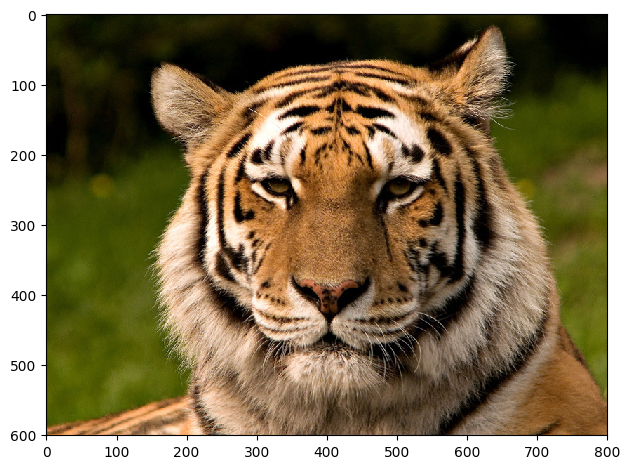

In [5]:
imshow(img)

### Вспомогательная функция для визуализации частот

In [6]:
def amplitudes(img):
    return np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(img))))

### Будем работать с яркостным каналом изображений

In [15]:
def get_y(img):
    img = img_as_float(img)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    y = 0.2126*r+0.7152*g+0.0722*b
    return y
def get_u(img):
    img = img_as_float(img)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    u =-0.0999*r-0.3360*g+0.4360*b
    return u
def get_u(img):
    img = img_as_float(img)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    v = 0.6150*r-0.5586*g-0.0563*b
    return v

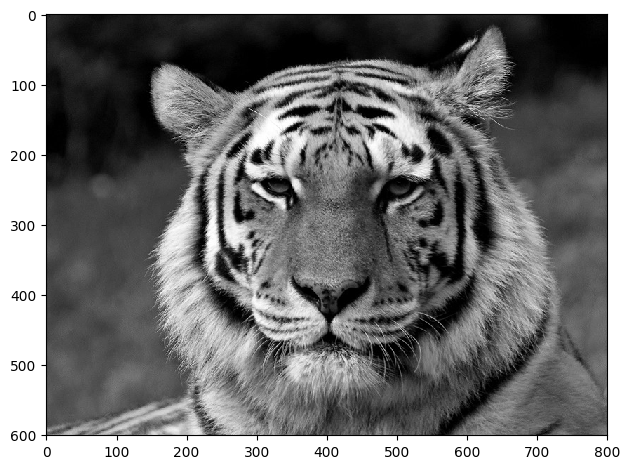

In [16]:
test_y = get_y(img)
imshow(test_y)

# 2, 3 Делаем функции для создания гауссовской и лапласовской пирамид

In [9]:

def gaussian_pyramid(img, sigma, n_layers):
    pyramid = [img]
    for _ in range(n_layers):
        img = convolve2d(img, gauss_kernel(sigma), mode='same')
        pyramid.append(img)
    return pyramid

def laplacian_pyramid(img, sigma, n_layers):
    gaussian = gaussian_pyramid(img, sigma, n_layers)
    pyramid = []
    for i in range(n_layers):
        expanded = convolve2d(gaussian[i + 1], gauss_kernel(sigma), mode='same')
        expanded = expanded[:gaussian[i].shape[0], :gaussian[i].shape[1]]  # Adjust the size of the expanded image
        residual = gaussian[i] - expanded
        pyramid.append(residual)
    pyramid.append(gaussian[-1])
    return pyramid

### Проводим тесты на тигре

In [10]:
l = laplacian_pyramid(test_y, 0.66, 6)
g = gaussian_pyramid(test_y, 0.66,6)

# Функция для визуализации результатов

In [11]:
def visualise(arr):
    fig, axes = plt.subplots(1, len(arr), figsize=(12, 8))
    for i in range(len(arr)):
        axes[i].imshow(arr[i], cmap='gray')
        axes[i].set_title(f'Image {i}')
    for ax in axes:
        ax.axis('off')

    # Adjust the layout
    plt.tight_layout()

    # Display the figure
    plt.show()


Так выглядит лапласовская пирамида

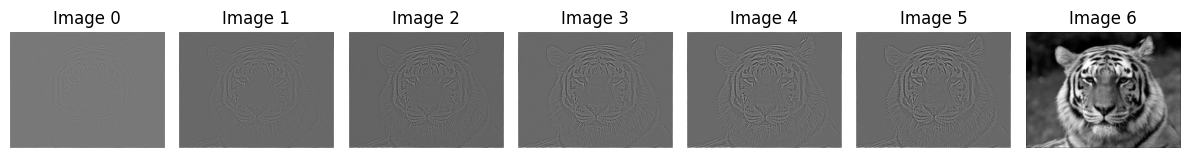

In [253]:
visualise(l)

А так гауссовская

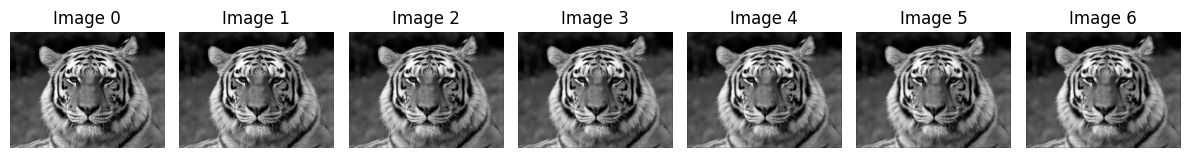

In [254]:
visualise(g)

Посмотрим на частоты этих пирамид. Можем заметить, что все работает как надо, и частот становится меньше

In [172]:
def apply_freq(arr):
    res=[]
    for i in arr:
        res.append(amplitudes(i))
    return res


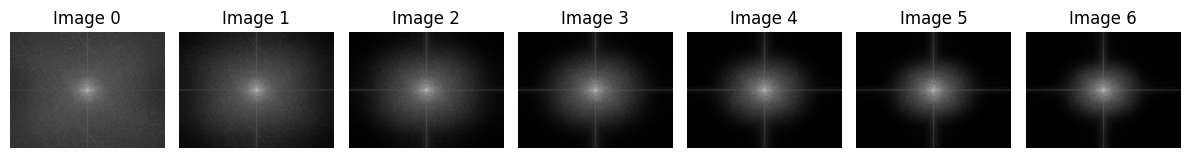

In [173]:
visualise(apply_freq(g))

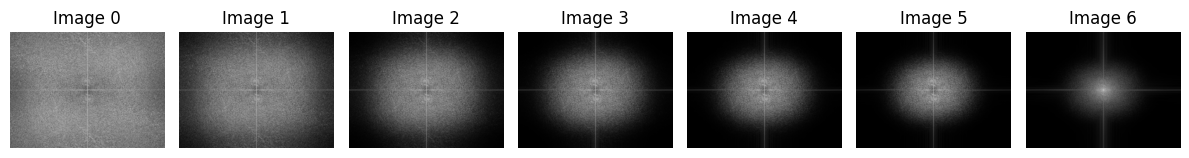

In [174]:
visualise(apply_freq(l))

# 4. Пробуем совместить изображения

In [256]:
a = imread('a.png')
b = imread('b.png')
m = imread('mask.png')

In [257]:
mask = get_y(m > 128).astype('uint')


In [258]:
masks = gaussian_pyramid(mask, 0.66, 6)

Вот так выглядит первая маска

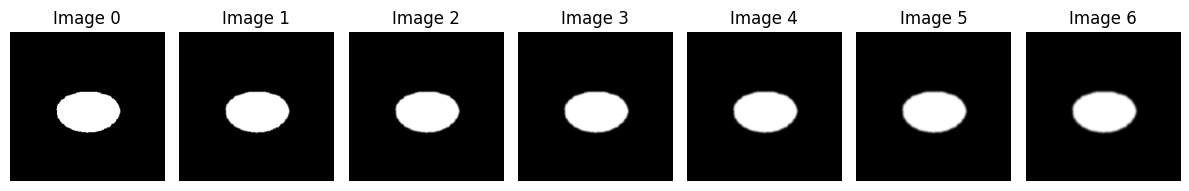

In [259]:
visualise(masks)

Пишем две функции. Glue работает с конкретным этапом пирамиды, glue_all - со всеми

In [12]:
def glue(gm, la, lb):
    return gm*la + (1-gm)*lb

In [13]:
def glue_all(img1, img2, mask, sigma, n_layers):
    res=[]
    masks = gaussian_pyramid(mask, sigma, n_layers)
    la = laplacian_pyramid(img1, sigma, n_layers)
    lb = laplacian_pyramid(img2, sigma, n_layers)
    for i in range(len(masks)):
        res.append(glue(masks[i], la[i], lb[i]))
    return res

In [264]:
results = glue_all(get_y(a),get_y(b),mask, 0.66, 6)

Так выглядит склейка на каждом этаже пирамиды

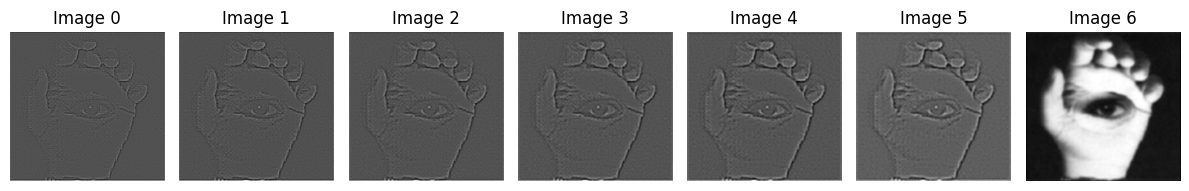

In [265]:
visualise(results)

Финальный результат

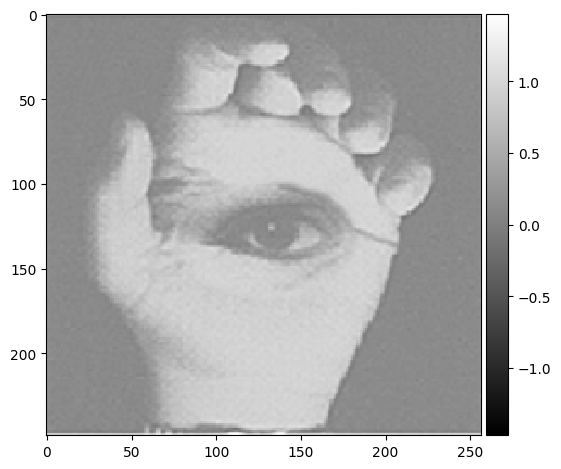

In [267]:
imshow(sum(results), cmap="gray")

# 5. Пробуем свои маски и изображения

In [269]:
a = imread('troll.png')
b = imread('moon.png')
m = imread('new_mask.png')
mask = get_y(m > 128).astype('uint')
results = glue_all(get_y(a),get_y(b),mask, 0.66, 6)


Исходные данные

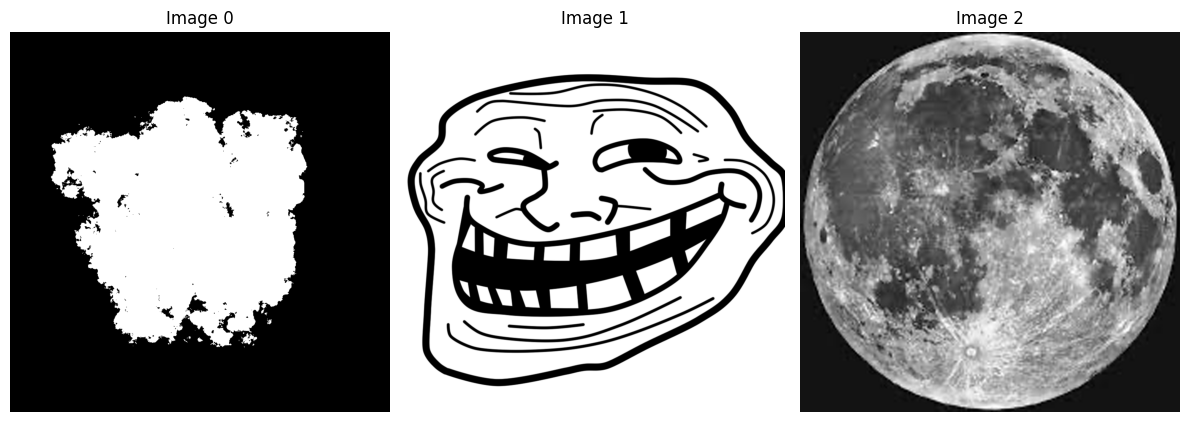

In [275]:
visualise([mask,a,b])

## Результаты

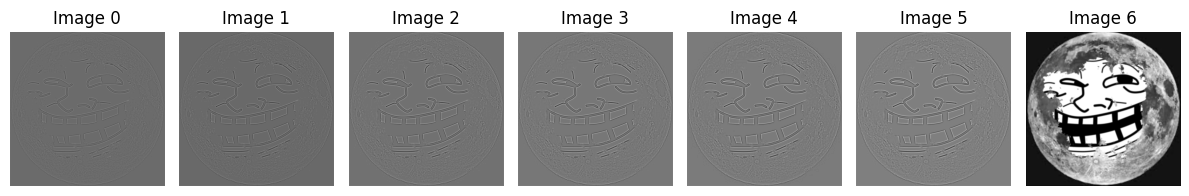

In [270]:
visualise(results)


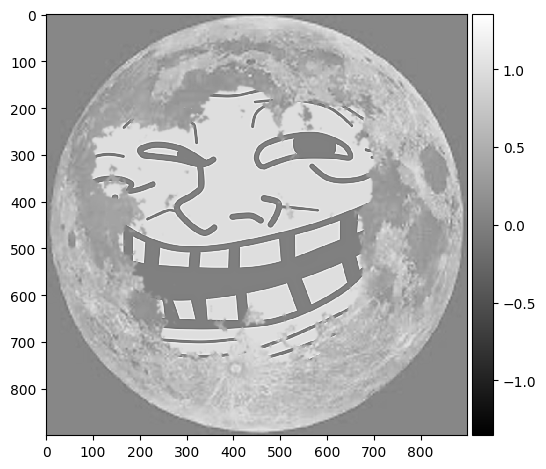

In [271]:
imshow(sum(results), cmap="gray")


При экспериментах с сигмой выяснилось, что самые интересные значения получились при сигме равной 0.9 и 1

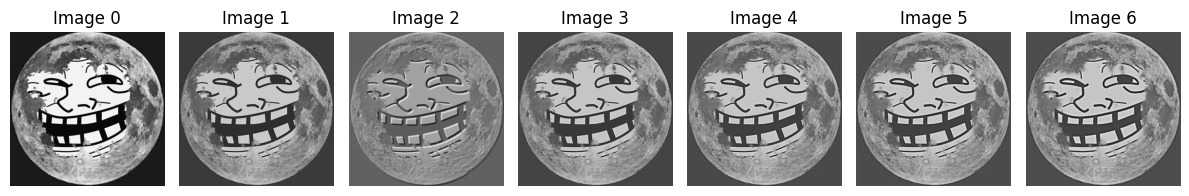

In [273]:
sigmas = (0.33, 0.66, 0.9, 1, 1.33, 1.66, 2)
res =[]
for i in sigmas:
    res.append(sum(glue_all(get_y(a),get_y(b),mask, i, 6)))
visualise(res)

### Пример с плохим фотошопом

In [280]:
a = imread('neymar.png')
b = imread('ronaldu.png')
m = imread('football.png')
mask = get_y(m > 128).astype('uint')
results = glue_all(get_y(a),get_y(b),mask, 0.9, 6)

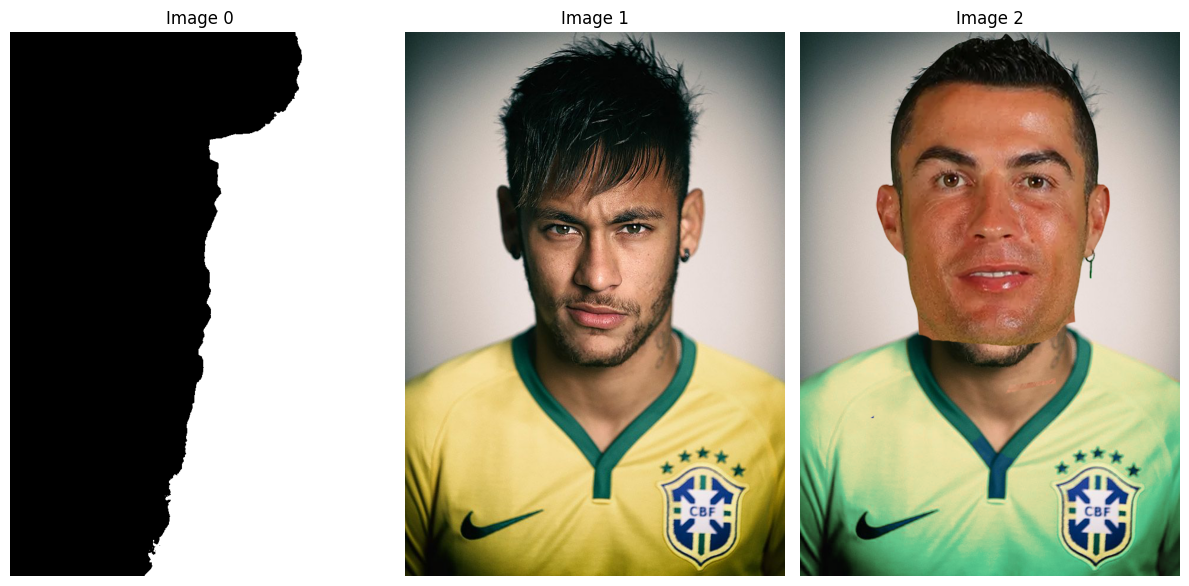

In [281]:
visualise([mask,a,b])


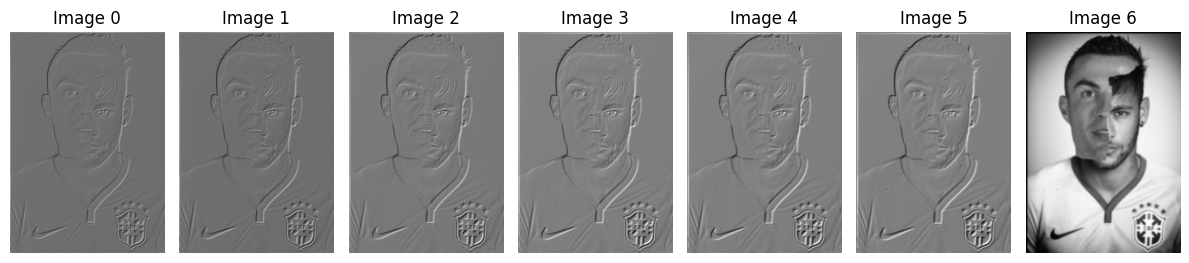

In [282]:
visualise(results)


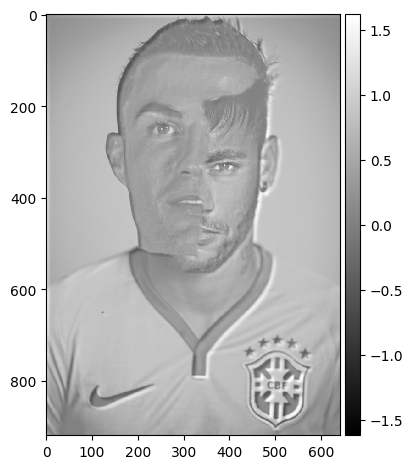

In [283]:
imshow(sum(results), cmap="gray")


In [18]:
a = imread('apple.png')
b = imread('orange.png')
m = imread('fruit.png')
mask = get_y(m > 128).astype('uint')
resultsY = glue_all(get_y(a),get_y(b),mask, 0.9, 6)
resultsU = glue_all(get_y(a),get_y(b),mask, 0.9, 6)
resultsV = glue_all(get_y(a),get_y(b),mask, 0.9, 6)


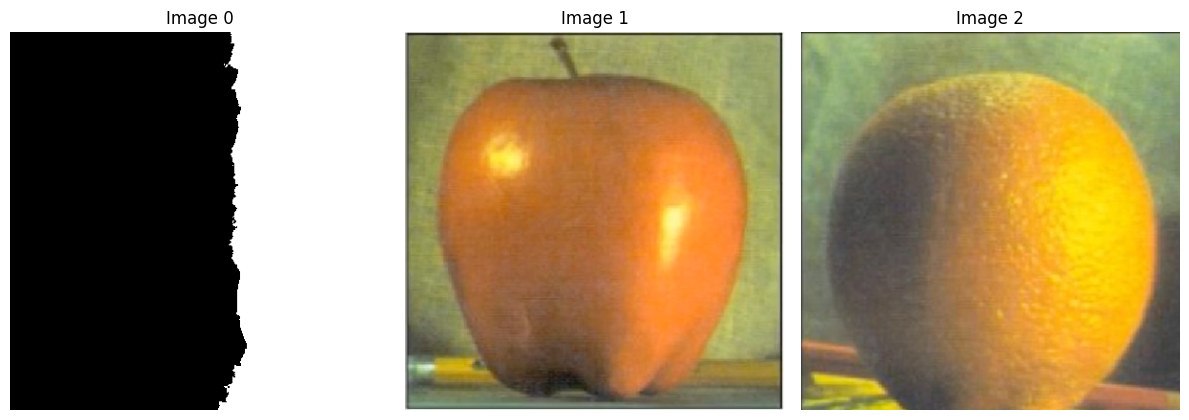

In [285]:
visualise([mask,a,b])


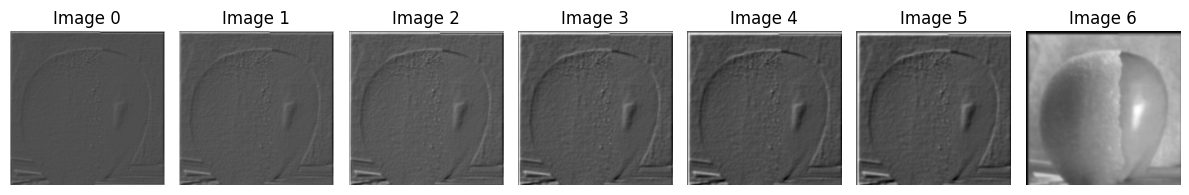

In [287]:
visualise(results)


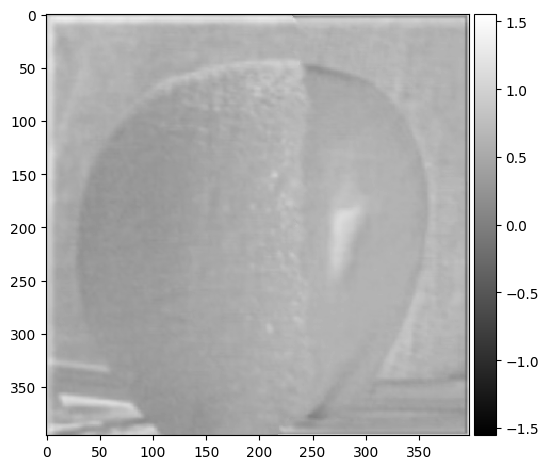

In [289]:
imshow(sum(results), cmap="gray")

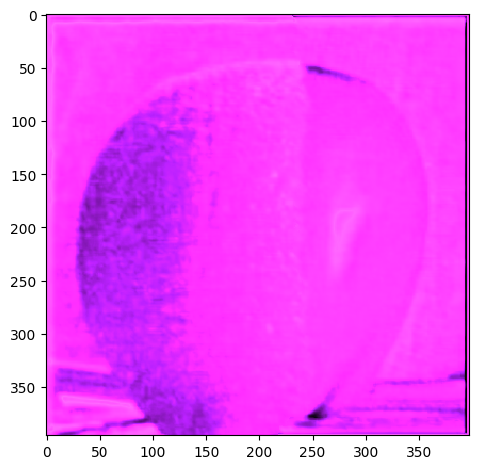

In [20]:
y = sum(resultsY)
y = np.clip(y, 0,1)
v = sum(resultsV)
u = sum(resultsU)
r=np.clip(y+1.2803*v, 0,1)
g = np.clip(y-0.2148*u-0.3805*v,0,1)
b = np.clip(y+2.1279*u, 0, 1)
imshow(np.dstack((r,g,b)))

In [2]:
a= set()
a.add("a")
a.add("b")
a[0]

TypeError: 'set' object is not subscriptable

In [5]:
print(5/-2)

-2.5


In [6]:
mas_one={1,3,4,4}
mas_two = {5,4}
if mas_one.intersection(mas_two)==set():
    print('no')
else:
    print(mas_one.intersection(mas_two))

{4}


In [7]:
num1 = "5"
num2 = 2.5
num3 = num1
text = num2
op1 = num2 * int(text) + float (num1)
op2 = str(int(op1)) + num1 * int(num3)
ор3 = text + num3
op4 = op1 * int(op2) // ор3
print(op4)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [11]:
number_one = 6.398
number_two = 4
answer = number_one / number_two
print(answer)

1.5995


In [14]:
mas_one = {11, 3, 4, 4}
mas_two = {5, 4}
if mas_one.intersection (mas_two) == set( ):
    print("Нет совпадений")
else:
    print(mas_one.intersection(mas_two))

{4}


In [15]:
Marks = dict()
Marks [вася] = 4
Marks [Петя] = 4
Marks [Костя] = 5
name = input( "Чью оценку вы хотите узнать?")
print("Оценка " + str(Marks [name]))

NameError: name 'вася' is not defined

In [16]:
A = list (map(int, input ("Введите список чисел: ") .split()))
while count < len(A):
    if A[count] % 2 == 0:
        print(A[count])
count = count + 1
    else:
        count = count + 1

SyntaxError: invalid syntax (1355630824.py, line 6)

In [17]:
num1 = "5"
num2 = 2.5
num3 = num1
text = num2
op1 = num2 * int(text) + float (num1)
op2 = str(int(op1)) + num1 * int(num3)
op3 = text + num3
op4 = op1 * int(op2) // ор3
print (op4)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [18]:
number_one = "5"
number_two = 9
number_three = int (number_one) * str (number_two)
number_four = int(str(number_three)) + 3
print(number_four)

100002


In [19]:
a = 9.23
b = 58
c = float (b) + int(a)
a = int(float (c))
b = float(b) * a
c = b + a * c

In [22]:
n = int (input())
k = 1
for i in range(1, n + 1):
    print(k)
    if i == k* (k + 1) // 2:
        k += 1

1
2
2
3
3
3
4
4
4
4
5


In [26]:
A = list(map(int, input().split()))
n = len(A)
for i in range(n):
    for j in range(n):
        if i - j > 0 and A[i] == A[j]:
            c += 1
print("count: " + c)

TypeError: can only concatenate str (not "float") to str